In [13]:
# action_types = ['idle', 'grenade', 'shield', 'reload', 'punch', 'spear', 'hammer', 'portal', 'spider', 'logout']
action_types = ['grenade', 'shield', 'reload', 'punch', 'spear', 'hammer', 'portal', 'spider', 'logout']

In [14]:
import tensorflow as tf
import platform

print(f'Python Platform: {platform.platform()}')
print(f'Tensorflow Version: {tf.__version__}')
gpu = len(tf.config.list_physical_devices('GPU'))>0
print('GPU is', 'available' if gpu else 'NOT AVAILABLE')

Python Platform: Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
Tensorflow Version: 2.13.0
GPU is NOT AVAILABLE


In [15]:
# Read CSV

import sys, os
import numpy as np
import pandas as pd
from pathlib import Path

def index_of_max_mag(df):
    return np.argmax([row['ax'] ** 2 + row['ay'] ** 2 + row['az'] ** 2 for index, row in df.iterrows()]).item()

fps = 40
target_frames = 80
total_axes = 7

cfd = sys.path[0]
data_folder = os.path.join('trim_util', 'raw_csv')
data_dir = os.path.join(cfd, data_folder)

X = []
y = []

for path in Path(data_dir).rglob('*.csv'):
    action_name = path

    while Path(action_name).parent != Path(data_dir):
        action_name = Path(action_name).parent.absolute()
    action_name = os.path.basename(action_name)
    
    y.append(action_types.index(action_name))

    df = pd.read_csv(path)

    if len(df) <= target_frames:
        first_row = df.iloc[[0]]
        first_row = pd.DataFrame(np.repeat(first_row.values, target_frames - len(df), axis=0), columns=list(df.columns))
        df = pd.concat([first_row, df], ignore_index=True).reset_index(drop = True)
    else:
        max_index = index_of_max_mag(df)
        if max_index - target_frames // 2 < 0:
            df = df.iloc[0 : target_frames]
        elif max_index + target_frames // 2 > len(df):
            df = df.iloc[len(df) - 1 - target_frames : len(df) - 1]
        else:
            df = df.iloc[max_index - target_frames // 2 : max_index + target_frames // 2]
        df.reset_index()
        
    X.append(df.to_numpy())

In [16]:
X = np.array(X)
X = X.astype(np.int32)
y = np.array(y)

# Normalize flex sensor from 10 bit to 16 bit
normalize_flex = lambda i: i * (2**15 / 2**10)
X[:,:,6] = np.vectorize(normalize_flex)(X[:,:,6])

# Convert to float
asfloat = lambda i: float(i + 2**15) / 2**15 - 1.0
X = np.vectorize(asfloat)(X)

# EXPERIMENTAL: Delete flex sensor column
# X = np.delete(X, 6, 2)
# total_axes = total_axes - 1

# EXPERIMENTAL: Delete gyro columns
# for i in range(5, 3):
#     X = np.delete(X, i, 2)
# total_axes = total_axes - 3

print(np.info(X))
print('len(y)', len(y))

class:  ndarray
shape:  (810, 80, 7)
strides:  (4480, 56, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x557c8e342940
byteorder:  little
byteswap:  False
type: float64
None
len(y) 810


In [17]:
# Normalize each sample for training

from scipy.stats import zscore
from scipy import signal

noscale_X = X.copy()

# Extract label

for sample in X:
    #signal.detrend(sample, axis=0)
    zscore(sample, axis=0)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

X_train.shape, X_test.shape

((648, 80, 7), (162, 80, 7))

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool2D, Input
from tensorflow.keras.optimizers import Adam

num_classes = len(action_types)

model = Sequential()
model.add(Input(shape=(80, total_axes)))
model.add(Conv1D(16, 5, activation='relu', strides=2))
model.add(Conv1D(32, 7, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 38, 16)            576       
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 32)            3616      
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 9)                 585       
                                                                 
Total params: 70377 (274.91 KB)
Trainable params: 7037

In [20]:
num_epochs = 16
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/16
21/21 [==============================] - 1s 9ms/step - loss: 2.1286 - accuracy: 0.2052 - val_loss: 1.9683 - val_accuracy: 0.3704
Epoch 2/16
21/21 [==============================] - 0s 5ms/step - loss: 1.8214 - accuracy: 0.3889 - val_loss: 1.5545 - val_accuracy: 0.5432
Epoch 3/16
21/21 [==============================] - 0s 5ms/step - loss: 1.4691 - accuracy: 0.4846 - val_loss: 1.2775 - val_accuracy: 0.5926
Epoch 4/16
21/21 [==============================] - 0s 5ms/step - loss: 1.2702 - accuracy: 0.5679 - val_loss: 1.2059 - val_accuracy: 0.5864
Epoch 5/16
21/21 [==============================] - 0s 4ms/step - loss: 1.1839 - accuracy: 0.5988 - val_loss: 1.1123 - val_accuracy: 0.6481
Epoch 6/16
21/21 [==============================] - 0s 4ms/step - loss: 1.1358 - accuracy: 0.6204 - val_loss: 1.0134 - val_accuracy: 0.6790
Epoch 7/16
21/21 [==============================] - 0s 4ms/step - loss: 0.9787 - accuracy: 0.6975 - val_loss: 0.9088 - val_accuracy: 0.7099
Epoch 8/16
21/21 [==

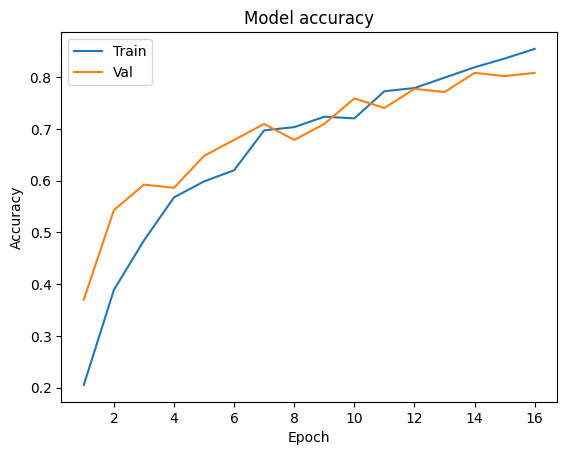

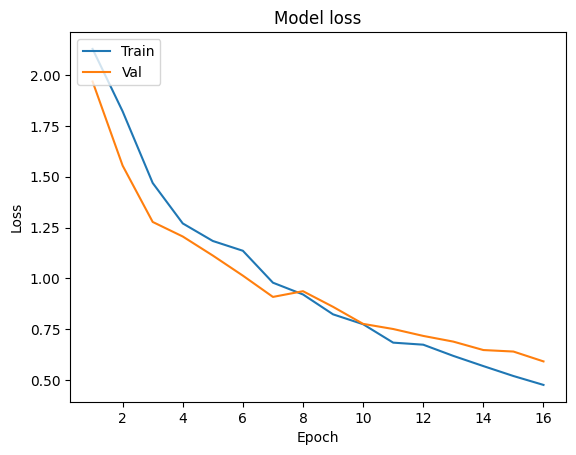

In [21]:
import matplotlib.pyplot as plt

def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, num_epochs)

6/6 [==============================] - 0s 2ms/step


(<Figure size 800x800 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

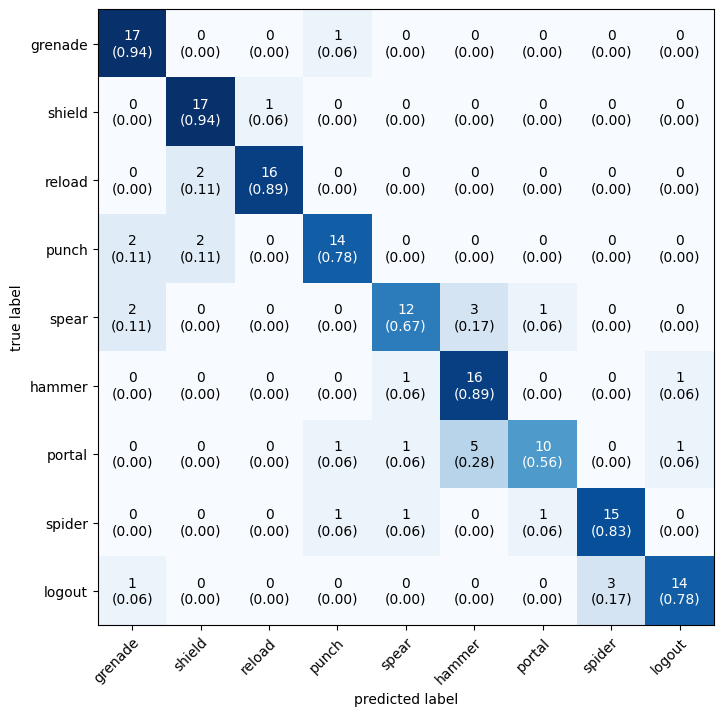

In [22]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# predict_classes generates class predictions for the input samples.

y_pred = model.predict(X_test)
y_classes = np.argmax(y_pred,axis=1)

mat = confusion_matrix(y_test, y_classes)
plot_confusion_matrix(conf_mat=mat, class_names=action_types, show_normed=True, figsize=(8,8))

In [23]:
# Save model
import os, sys

# The weights are arranged in such a way that: 
#   weights[x] contains data for each column in each filter
#   weights[][y] contains data for each row in each filter
#   weights[][][z] indexes each filter
# So weights[8][4][0] references the 8th column and 4th row of the 0th filter.

# First Conv1D weights
cfd = sys.path[0]
folder_name = os.path.join('HLS_CNN', 'cpp_source')
conv1_w = open(os.path.join(cfd, folder_name, 'conv1_weights.txt'), "w")
tensor = model.layers[0].get_weights()[0]

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        for k in range(len(tensor[0][0])):
            conv1_w.write(str(tensor[i][j][k]))
            if i < len(tensor) - 1 or j < len(tensor[0]) - 1 or k < len(tensor[0][0]) - 1:
                conv1_w.write(',')

conv1_w.close()

# First Conv1D biases
conv1_b = open(os.path.join(cfd, folder_name, 'conv1_biases.txt'), "w")
biases = model.layers[0].get_weights()[1]
conv1_b.write(",".join(str(x) for x in biases))
conv1_b.close()

# Second Conv1D weights
cfd = sys.path[0]
conv2_w = open(os.path.join(cfd, folder_name, 'conv2_weights.txt'), "w")
tensor = model.layers[1].get_weights()[0]

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        for k in range(len(tensor[0][0])):
            conv2_w.write(str(tensor[i][j][k]))
            if i < len(tensor) - 1 or j < len(tensor[0]) - 1 or k < len(tensor[0][0]) - 1:
                conv2_w.write(',')

conv2_w.close()

# Second Conv1D biases
conv2_b = open(os.path.join(cfd, folder_name, 'conv2_biases.txt'), "w")
biases = model.layers[1].get_weights()[1]
conv2_b.write(",".join(str(x) for x in biases))
conv2_b.close()

# First dense layer weights
tensor = model.layers[3].get_weights()[0]

dense1_w = open(os.path.join(cfd, folder_name, 'dense1_weights.txt'), "w")

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        dense1_w.write(str(tensor[i][j]))
        if i < len(tensor) - 1 or j < len(tensor[0]) - 1:
            dense1_w.write(',')

dense1_w.close()

# First dense layer biases
dense1_b = open(os.path.join(cfd, folder_name, 'dense1_biases.txt'), "w")
biases = model.layers[3].get_weights()[1]
dense1_b.write(",".join(str(x) for x in biases))
dense1_b.close()

# Second dense layer weights
tensor = model.layers[5].get_weights()[0]

dense2_w = open(os.path.join(cfd, folder_name, 'dense2_weights.txt'), "w")

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        dense2_w.write(str(tensor[i][j]))
        if i < len(tensor) - 1 or j < len(tensor[0]) - 1:
            dense2_w.write(',')

dense2_w.close()

# Second dense layer biases
dense2_b = open(os.path.join(cfd, folder_name, 'dense2_biases.txt'), "w")
biases = model.layers[5].get_weights()[1]
dense2_b.write(",".join(str(x) for x in biases))
dense2_b.close()

In [24]:
# Test against C++
import subprocess

#test_result = subprocess.run([out_loc, '<', test_loc], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
test_loc = os.path.join(cfd, folder_name, 'test.in')
out_loc = os.path.join(cfd, folder_name, 'a.out')

total_tests = 20
total_correct = 0
total_vs_nn = 0
total_nn_correct = 0

test_list = []
test_answers = []
cpp_answer = []

subprocess.run('make', cwd=os.path.join(cfd, folder_name))

for i in range(total_tests):
    choice = np.random.randint(0, len(X))
    test_list.append(X[choice])
    test_answers.append(y[choice])
    
    Xflat = noscale_X[choice].flatten()
    np.savetxt(test_loc, Xflat)
    test_pipe = subprocess.Popen(['cat', test_loc], stdout=subprocess.PIPE)
    out_pipe = subprocess.Popen([out_loc], stdin=test_pipe.stdout, stdout=subprocess.PIPE)
    output = out_pipe.communicate()[0].decode('ascii')
    cpp_answer.append(int(output))

    if int(output) == y[choice]:
        total_correct += 1

prediction = model.predict(tf.reshape(test_list, [total_tests, 80, 7]))

for i in range(total_tests):
    if cpp_answer[i] == np.argmax(prediction[i]):
        total_vs_nn += 1
    if test_answers[i] == np.argmax(prediction[i]):
        total_nn_correct += 1

print('Total tests:', total_tests)
print('Total equal to pyNN:', total_vs_nn)
print('Total correct:', total_correct)
print('% =pyNN:', total_vs_nn / total_tests)
print('pyNN % correct:', total_nn_correct / total_tests)
print('CPP % correct:', total_correct / total_tests)

g++ -g -Wfatal-errors -Wpedantic -pedantic-errors -Wall -Wextra *.cpp 
1/1 [==============================] - 0s 46ms/step
Total tests: 20
Total equal to pyNN: 20
Total correct: 18
% =pyNN: 1.0
pyNN % correct: 0.9
CPP % correct: 0.9


In [25]:
# Print input tests

num_tests = 3

# Cleanup
store_dir = os.path.join(cfd, 'HLS_CNN')
for file in os.listdir(store_dir):
    if file.lower().endswith('.in'):
        os.remove(os.path.join(store_dir, file))

for i in range(num_tests):
    choice = np.random.randint(0, len(X))
    
    Xflat = noscale_X[choice].flatten()
    np.savetxt(test_loc, Xflat)
    test_pipe = subprocess.Popen(['cat', test_loc], stdout=subprocess.PIPE)
    out_pipe = subprocess.Popen([out_loc], stdin=test_pipe.stdout, stdout=subprocess.PIPE)
    output = out_pipe.communicate()[0].decode('ascii')

    filename = 'test' + str(i) + '_answer' + output + '.in'
    test_output = open(os.path.join(store_dir, filename), "w")
    test_output.write(",".join(str(x) for x in Xflat))
    test_output.close()